In [29]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tqdm import tqdm
import shutil
import time

In [5]:
# --- CONFIGURATION ---
DATA_ROOT = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2"  # Your root folder
NORMAL_CLASS_NAME = "NormalVideos" # Change this if your folder is named 'Normal_Videos_event'
STAGE_2_DATA_ROOT = "stage2_extracted_frames" # Where we will save frames for Stage 2

# Hyperparameters
BATCH_SIZE = 8
NUM_SEGMENTS = 16  # How many clips/frames to sample per video in Stage 1
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOP_N_FRAMES = 5   # How many "evidence" frames to extract per video for Stage 2

print(f"Running on device: {DEVICE}")

Running on device: cuda


In [3]:
class UCFCrimeBinaryDataset(Dataset):
    def __init__(self, root_dir, split="Train", num_segments=16, transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.num_segments = num_segments
        self.samples = [] 
        
        # Walk through directories
        for class_name in os.listdir(self.root_dir):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path): continue
            
            # Binary Label: 0 if Normal, 1 if Crime
            label = 0 if class_name == NORMAL_CLASS_NAME else 1
            
            for vid_file in os.listdir(class_path):
                self.samples.append((os.path.join(class_path, vid_file), label, class_name))

    def __len__(self):
        return len(self.samples)

    def load_video_segments(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames < 1: return torch.zeros(self.num_segments, 3, IMG_SIZE, IMG_SIZE)

        # Uniform sampling
        indices = np.linspace(0, total_frames-1, self.num_segments).astype(int)
        
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
            else:
                # Padding if read fails
                frames.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))
        cap.release()
        
        # Stack to shape (Segments, C, H, W)
        return torch.stack(frames) if frames else torch.zeros(self.num_segments, 3, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        path, label, original_class = self.samples[idx]
        video_tensor = self.load_video_segments(path) # Shape: (T, C, H, W)
        return video_tensor, torch.tensor(label, dtype=torch.float32), path, original_class

# --- STAGE 1 MODEL: MIL ResNet ---
class Stage1MILModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature Extractor (ResNet18)
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1]) # Remove fc
        
        # Classifier Head (Instance Level)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (Batch, Segments, C, H, W)
        b, t, c, h, w = x.size()
        
        # Merge Batch and Time for CNN processing
        x = x.view(b * t, c, h, w) 
        
        features = self.feature_extractor(x) # (B*T, 512, 1, 1)
        features = features.view(features.size(0), -1) # (B*T, 512)
        
        # Get instance (segment) scores
        segment_scores = self.classifier(features) # (B*T, 1)
        
        # Reshape back to (Batch, Segments)
        segment_scores = segment_scores.view(b, t)
        
        # MIL Aggregation: Max Pooling (The video score is the max segment score)
        # We return both the video score AND the segment scores (for frame extraction)
        video_score, _ = torch.max(segment_scores, dim=1)
        
        return video_score, segment_scores

In [4]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.4, gamma=1.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        # inputs: model predictions (after sigmoid)
        # targets: ground truth labels
        bce_loss = -targets * torch.log(inputs + 1e-8) - (1 - targets) * torch.log(1 - inputs + 1e-8)
        pt = torch.where(targets == 1, inputs, 1 - inputs)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loaders
train_ds_s1 = UCFCrimeBinaryDataset(DATA_ROOT, split="Train", transform=train_transform)
test_ds_s1 = UCFCrimeBinaryDataset(DATA_ROOT, split="Test", transform=test_transform)
val_ds_s1 = UCFCrimeBinaryDataset(DATA_ROOT, split="Validation", transform=test_transform)

train_loader_s1 = DataLoader(train_ds_s1, batch_size=BATCH_SIZE, shuffle=True)
test_loader_s1 = DataLoader(test_ds_s1, batch_size=1, shuffle=False) # Batch 1 for easier extraction

# Init Model
model_s1 = Stage1MILModel().to(DEVICE)
optimizer_s1 = optim.Adam(model_s1.parameters(), lr=1e-4)
criterion_s1 = FocalLoss(alpha=0.4, gamma=3.0)

# --- TRAINING LOOP STAGE 1 ---
def train_stage1(epochs=1):
    model_s1.train()
    history = {'train_loss': [], 'train_acc': [], 'train_f1': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []
        
        loop = tqdm(train_loader_s1, desc=f"Stage 1 Epoch {epoch+1}")
        for videos, labels, _, _ in loop:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            
            optimizer_s1.zero_grad()
            video_preds, _ = model_s1(videos)
            
            loss = criterion_s1(video_preds, labels)
            loss.backward()
            optimizer_s1.step()
            
            epoch_loss += loss.item()
            
            # Track predictions for metrics
            preds_binary = (video_preds > 0.5).float()
            all_preds.extend(preds_binary.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader_s1)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='binary')
        
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(accuracy)
        history['train_f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")

    elapsed_time = time.time() - start_time
    print(f"\nStage 1 Training completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    
    return history

# Run Training
print("Starting Stage 1 Training...")
stage1_history = train_stage1(epochs=6) # Increase epochs for real results

# --- THE PIPE: EXTRACTION ---
# We will iterate through the dataset. If the model says "Crime" (or if it IS a crime in training),
# we extract top N frames and save them for Stage 2.

def extract_frames_for_stage2(dataset, split_name):
    print(f"Extracting frames for {split_name}...")
    model_s1.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    start_time = time.time()
    
    import glob

    with torch.no_grad():
        for videos, labels, paths, original_classes in tqdm(loader):
            videos = videos.to(DEVICE)
            path = paths[0]
            orig_class = original_classes[0]
            
            # Skip Normal videos for Stage 2 (we only want to classify crime types)
            if orig_class == NORMAL_CLASS_NAME:
                continue

            # Get scores
            video_score, segment_scores = model_s1(videos)
            
            # Identify Top N indices
            # segment_scores is shape (1, NUM_SEGMENTS)
            scores = segment_scores[0].cpu().numpy()
            top_indices = scores.argsort()[-TOP_N_FRAMES:][::-1] # Indices of highest scores
            
            # Prepare save directory
            # e.g., stage2_extracted/Train/Abuse/
            save_dir = os.path.join(STAGE_2_DATA_ROOT, split_name, orig_class)
            os.makedirs(save_dir, exist_ok=True)

            # Remove any existing frames for this video in the save_dir to avoid stale files causing issues
            vid_name = os.path.basename(path).split('.')[0]
            existing_pattern = os.path.join(save_dir, f"{vid_name}_rank*.jpg")
            for f in glob.glob(existing_pattern):
                try:
                    os.remove(f)
                except Exception:
                    pass

            # Extract actual frames from video file using the indices
            cap = cv2.VideoCapture(path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            # Map segment index back to frame number
            frame_indices_to_grab = np.linspace(0, total_frames-1, NUM_SEGMENTS).astype(int)[top_indices]

            for rank, frame_idx in enumerate(frame_indices_to_grab):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    save_path = os.path.join(save_dir, f"{vid_name}_rank{rank}.jpg")
                    cv2.imwrite(save_path, frame)
            cap.release()
    
    elapsed_time = time.time() - start_time
    print(f"Frame extraction for {split_name} completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Run Extraction
extract_frames_for_stage2(train_ds_s1, "Train")
extract_frames_for_stage2(test_ds_s1, "Test")
extract_frames_for_stage2(val_ds_s1, "Validation")

Starting Stage 1 Training...
Stage 1 Epoch 1: 100%|██████████| 117/117 [02:30<00:00,  1.28s/it, loss=0.0121] 
Epoch 1/6 - Loss: 0.0214, Acc: 0.8387, F1: 0.9059
Stage 1 Epoch 2: 100%|██████████| 117/117 [02:20<00:00,  1.19s/it, loss=0.00887]
Epoch 2/6 - Loss: 0.0165, Acc: 0.8645, F1: 0.9179
Stage 1 Epoch 3: 100%|██████████| 117/117 [02:20<00:00,  1.19s/it, loss=0.000508]
Epoch 3/6 - Loss: 0.0154, Acc: 0.8914, F1: 0.9346
Stage 1 Epoch 4: 100%|██████████| 117/117 [02:18<00:00,  1.18s/it, loss=0.0718] 
Epoch 4/6 - Loss: 0.0160, Acc: 0.8946, F1: 0.9366
Stage 1 Epoch 5: 100%|██████████| 117/117 [02:18<00:00,  1.18s/it, loss=0.00214]
Epoch 5/6 - Loss: 0.0139, Acc: 0.9065, F1: 0.9438
Stage 1 Epoch 6: 100%|██████████| 117/117 [02:18<00:00,  1.18s/it, loss=0.00766]
Epoch 6/6 - Loss: 0.0110, Acc: 0.9226, F1: 0.9531

Stage 1 Training completed in 844.14 seconds (14.07 minutes)
Extracting frames for Train...
100%|██████████| 930/930 [04:42<00:00,  3.30it/s]
Frame extraction for Train completed in 2

Evaluating Stage 1: 100%|██████████| 245/245 [00:53<00:00,  4.59it/s]


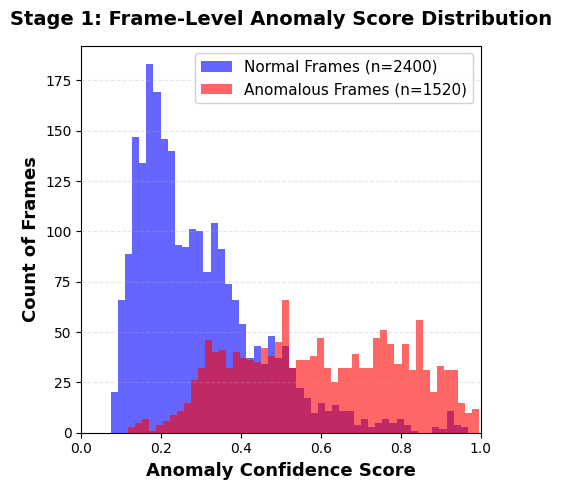

Stage 1 Test Accuracy: 81.22%
Stage 1 Test F1 Score: 0.7850


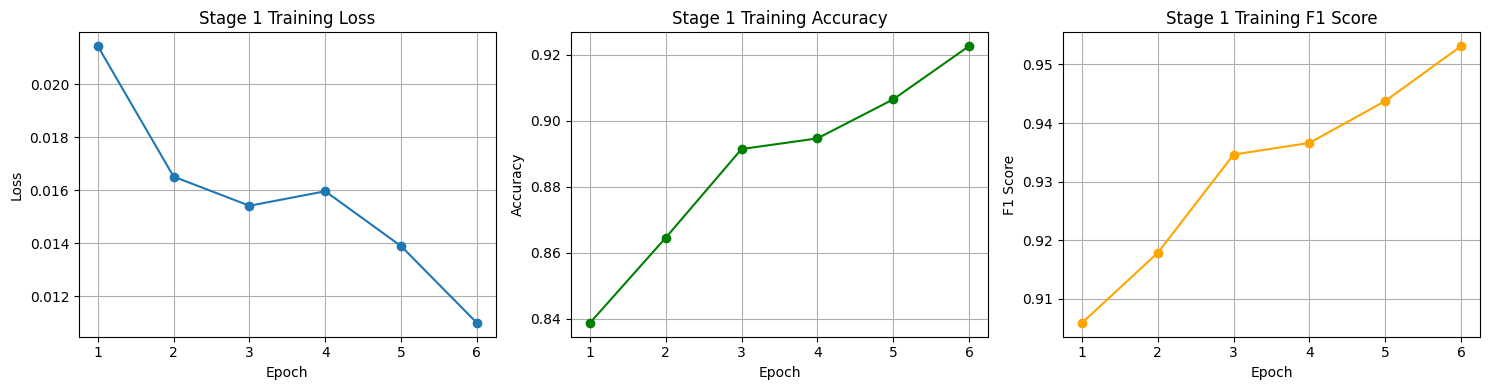

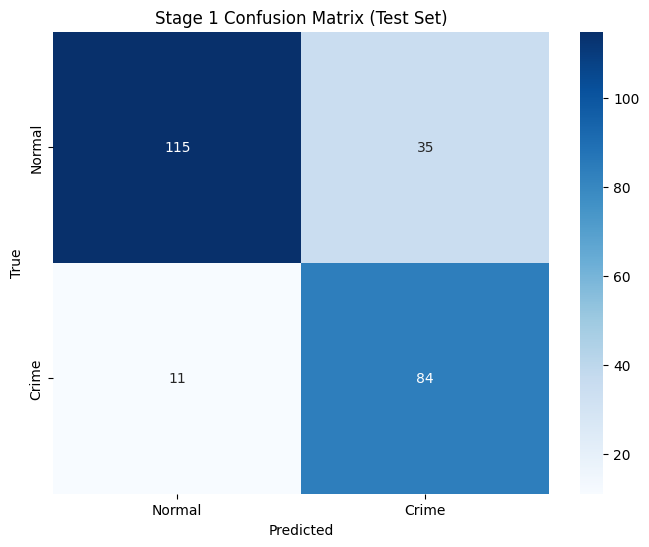

In [ ]:
# --- STAGE 1 EVALUATION AND VISUALIZATION ---

def evaluate_stage1(loader, model, num_segments=16, plot_distribution=True, bins=50):
    """
    Evaluate Stage 1 model and optionally plot frame-level anomaly score distribution.
    
    Args:
        loader: DataLoader for evaluation
        model: Trained Stage 1 model
        num_segments: Number of segments per video
        plot_distribution: Whether to plot the frame-level score distribution
        bins: Number of bins for histogram
    
    Returns:
        acc, f1, cm, all_preds, all_labels, normal_frame_scores, anomaly_frame_scores
    """
    model.eval()
    all_preds = []
    all_labels = []
    normal_frame_scores = []
    anomaly_frame_scores = []
    
    with torch.no_grad():
        for videos, labels, _, _ in tqdm(loader, desc="Evaluating Stage 1"):
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            video_preds, segment_scores = model(videos)
            preds_binary = (video_preds > 0.5).float()
            
            all_preds.extend(preds_binary.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect frame-level scores for distribution
            for i in range(len(labels)):
                scores = segment_scores[i].cpu().numpy()
                
                if labels[i].item() == 0:  # Normal
                    normal_frame_scores.extend(scores)
                else:  # Anomaly
                    anomaly_frame_scores.extend(scores)
    
    # Convert to numpy arrays
    normal_frame_scores = np.array(normal_frame_scores)
    anomaly_frame_scores = np.array(anomaly_frame_scores)
    
    # Calculate video-level metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot frame-level anomaly score distribution
    if plot_distribution:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Create histograms
        ax.hist(normal_frame_scores, bins=bins, alpha=0.6, color='blue', 
                label=f'Normal Frames (n={len(normal_frame_scores)})', linewidth=0.5)
        ax.hist(anomaly_frame_scores, bins=bins, alpha=0.6, color='red', 
                label=f'Anomalous Frames (n={len(anomaly_frame_scores)})', linewidth=0.5)
        
        # Labels and title
        ax.set_xlabel('Anomaly Confidence Score', fontsize=13, fontweight='bold')
        ax.set_ylabel('Count of Frames', fontsize=13, fontweight='bold')
        ax.set_title('Stage 1: Frame-Level Anomaly Score Distribution', 
                     fontsize=14, fontweight='bold', pad=15)
        
        # Add grid and legend
        ax.grid(True, alpha=0.3, linestyle='--', axis='y')
        ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
        
        # Set x-axis limits
        ax.set_xlim(0, 1)
        
        
        plt.tight_layout()
        plt.show()
        
    
    return acc, f1, cm, all_preds, all_labels, normal_frame_scores, anomaly_frame_scores


# Evaluate on test set (now includes frame-level distribution)
test_acc, test_f1, test_cm, test_preds, test_labels, normal_scores, anomaly_scores = evaluate_stage1(
    test_loader_s1, model_s1, num_segments=NUM_SEGMENTS, plot_distribution=True, bins=50
)

print(f"Stage 1 Test Accuracy: {test_acc*100:.2f}%")
print(f"Stage 1 Test F1 Score: {test_f1:.4f}")

# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(range(1, len(stage1_history['train_loss'])+1), stage1_history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Stage 1 Training Loss')
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, len(stage1_history['train_acc'])+1), stage1_history['train_acc'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Stage 1 Training Accuracy')
axes[1].grid(True)

# F1 Score plot
axes[2].plot(range(1, len(stage1_history['train_f1'])+1), stage1_history['train_f1'], marker='o', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Stage 1 Training F1 Score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', xticklabels=['Normal', 'Crime'], yticklabels=['Normal', 'Crime'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Stage 1 Confusion Matrix (Test Set)')
plt.show()


In [12]:
# --- STAGE 1: VIDEO CONFIDENCE OVER TIME VISUALIZATION ---

def get_video_confidence_timeline(model, video_path, num_segments=16, top_n=5):
    """
    Extract frame-by-frame confidence scores for a video.
    Returns frame indices, confidence scores, and top N frame indices.
    """
    model.eval()
    
    # Load video and get all sampled frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < 1:
        cap.release()
        return None, None, None
    
    # Get the frame indices that were sampled
    frame_indices = np.linspace(0, total_frames-1, num_segments).astype(int)
    
    # Load and process each frame
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frame = test_transform(frame)
            frames.append(frame)
        else:
            frames.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))
    
    cap.release()
    
    # Stack frames and get predictions
    video_tensor = torch.stack(frames).unsqueeze(0).to(DEVICE)  # Shape: (1, T, C, H, W)
    
    with torch.no_grad():
        video_score, segment_scores = model(video_tensor)
    
    # Get segment scores (confidence of being anomalous/crime)
    segment_scores = segment_scores[0].cpu().numpy()  # Shape: (num_segments,)
    
    # Get top N frame indices
    top_indices = segment_scores.argsort()[-top_n:][::-1]
    top_frame_numbers = frame_indices[top_indices]
    
    return frame_indices, segment_scores, top_frame_numbers, video_score.item()


In [22]:
def plot_video_confidence_timeline(video_name, model, test_dataset, save_path=None):
    """
    Plot the confidence timeline for a specific video by name.
    
    Args:
        video_name: Name of the video file (e.g., "Abuse001_x264.mp4")
        model: Trained Stage 1 model
        test_dataset: The test dataset object
        save_path: Optional path to save the figure
    """
    # Find the video in the dataset
    video_path = None
    video_label = None
    video_class = None
    
    for path, label, orig_class in test_dataset.samples:
        if video_name in path:
            video_path = path
            video_label = label
            video_class = orig_class
            break
    
    if video_path is None:
        print(f"Video '{video_name}' not found in test dataset!")
        return
    
    # Get confidence timeline
    frame_indices, confidences, top_frames, overall_score = get_video_confidence_timeline(
        model, video_path, num_segments=NUM_SEGMENTS, top_n=TOP_N_FRAMES
    )
    
    if frame_indices is None:
        print(f"Failed to process video: {video_name}")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot confidence scores (no markers on the line itself)
    ax.plot(frame_indices, confidences, linewidth=2, color='#2E86AB', label='Anomaly Confidence')
    

    
    # Add horizontal line at 0.5 threshold
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (0.5)')
    
    # Group sequential top frames and highlight them
    # Sort top frames to check for sequential frames
    sorted_top_frames = np.sort(top_frames)
    
    # Find groups of sequential frames
    groups = []
    current_group = [sorted_top_frames[0]]
    
    for i in range(1, len(sorted_top_frames)):
        # Check if frames are adjacent in the original frame_indices
        current_idx = np.where(frame_indices == sorted_top_frames[i])[0][0]
        prev_idx = np.where(frame_indices == sorted_top_frames[i-1])[0][0]
        
        if current_idx - prev_idx == 1:  # Sequential frames
            current_group.append(sorted_top_frames[i])
        else:
            groups.append(current_group)
            current_group = [sorted_top_frames[i]]
    
    groups.append(current_group)  # Add the last group
    
    # Highlight each group with merged bars
    y_min, y_max = ax.get_ylim()
    for i, group in enumerate(groups):
        # For each group, create one wide bar that spans all frames
        start_frame = group[0] - 10
        end_frame = group[-1] + 10
        ax.axvspan(start_frame, end_frame, alpha=0.15, color="#FF0000", 
                   label='Top Evidence Region' if i == 0 else '')
    
    # Labels and title
    ax.set_xlabel('Frame Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Anomaly Confidence Score', fontsize=12, fontweight='bold')
    
    true_label = "Normal" if video_label == 0 else "Anomalous"
    pred_label = "Anomalous" if overall_score > 0.5 else "Normal"
    
    title = f'Video Anomaly Confidence Timeline\n'
    title += f'Video: {video_name} | True Label: {true_label} ({video_class}) | '
    title += f'Predicted: {pred_label} (Score: {overall_score:.3f})'
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    
    # Add grid and legend
    ax.grid(True, alpha=0.5, linestyle='--', linewidth=0.8, color='gray')
    ax.legend(loc='upper left', fontsize=10)
    
    # Set axis limits to match the data range
    ax.set_xlim(frame_indices[0], frame_indices[-1])
    ax.set_ylim(-0.05, 1.05)
    
    # Add axis spines (borders) for x and y axes
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['top'].set_color('black')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Video: {video_name}")
    print(f"True Label: {true_label} ({video_class})")
    print(f"Overall Anomaly Score: {overall_score:.4f}")
    print(f"Prediction: {pred_label}")
    print(f"\nTop {TOP_N_FRAMES} Evidence Frames:")
    for i, (frame_num, score) in enumerate(zip(top_frames, confidences[np.isin(frame_indices, top_frames)])):
        print(f"  #{i+1}: Frame {frame_num} (Confidence: {score:.4f})")
    print(f"{'='*60}\n")

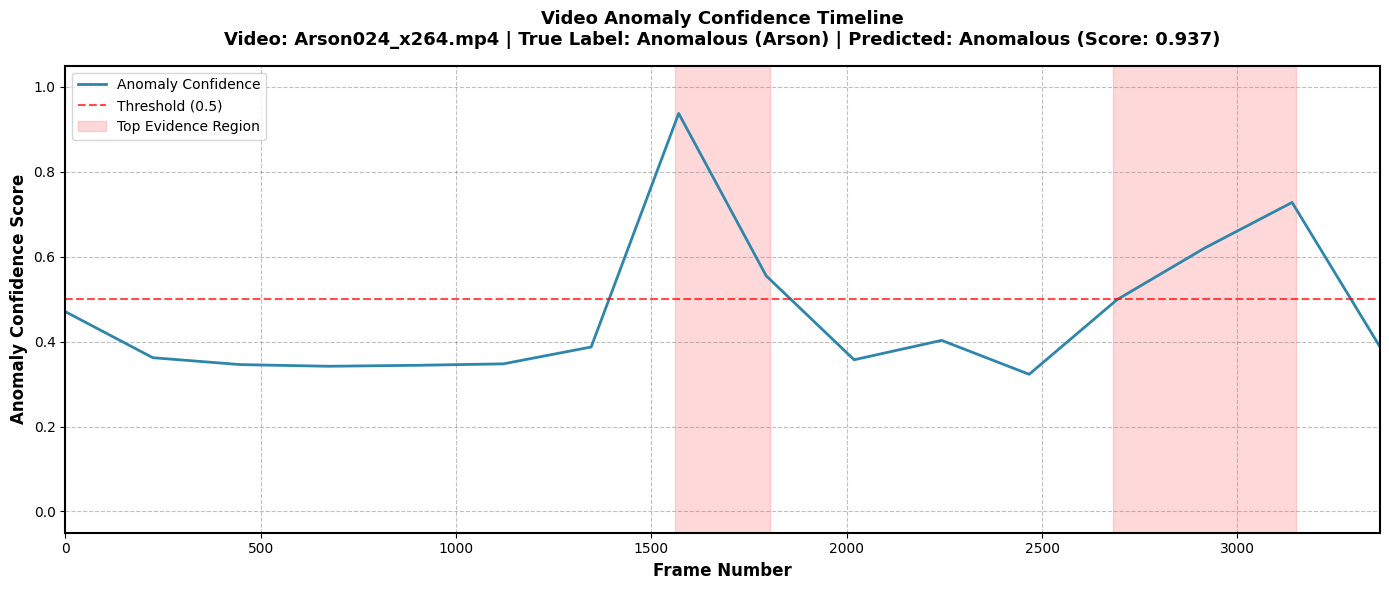


Video: Arson024_x264.mp4
True Label: Anomalous (Arson)
Overall Anomaly Score: 0.9374
Prediction: Anomalous

Top 5 Evidence Frames:
  #1: Frame 1570 (Confidence: 0.9374)
  #2: Frame 3140 (Confidence: 0.5550)
  #3: Frame 2916 (Confidence: 0.4989)
  #4: Frame 1794 (Confidence: 0.6203)
  #5: Frame 2692 (Confidence: 0.7278)



In [23]:
plot_video_confidence_timeline("Arson024_x264.mp4", model_s1, test_ds_s1)

In [10]:
# --- STAGE 2 DATASET ---
# Standard ImageFolder works because we organized data into folders by class
from torchvision.datasets import ImageFolder

transform_s2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_ds_s2 = ImageFolder(os.path.join(STAGE_2_DATA_ROOT, "Train"), transform=transform_s2)
test_ds_s2 = ImageFolder(os.path.join(STAGE_2_DATA_ROOT, "Test"), transform=transform_s2)

train_loader_s2 = DataLoader(train_ds_s2, batch_size=32, shuffle=True)
test_loader_s2 = DataLoader(test_ds_s2, batch_size=32, shuffle=False)

num_classes_s2 = len(train_ds_s2.classes)
print(f"Stage 2 Classes: {train_ds_s2.classes}")

# --- STAGE 2 MODEL: Vision Transformer ---
# Using a pretrained ViT
model_s2 = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

# Modify the head for our number of crime classes
model_s2.heads.head = nn.Linear(model_s2.heads.head.in_features, num_classes_s2)
model_s2 = model_s2.to(DEVICE)

optimizer_s2 = optim.AdamW(model_s2.parameters(), lr=1e-6) # Lower LR for ViT fine-tuning
criterion_s2 = nn.CrossEntropyLoss()

# --- TRAINING LOOP STAGE 2 ---
def train_stage2(epochs=1):
    model_s2.train()
    history = {'train_loss': [], 'train_acc': [], 'train_f1': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []
        
        loop = tqdm(train_loader_s2, desc=f"Stage 2 Epoch {epoch+1}")
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer_s2.zero_grad()
            outputs = model_s2(images)
            loss = criterion_s2(outputs, labels)
            
            loss.backward()
            optimizer_s2.step()
            
            epoch_loss += loss.item()
            
            # Track predictions for metrics
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader_s2)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(accuracy)
        history['train_f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")
    
    return history

print("Starting Stage 2 Training...")
stage2_history = train_stage2(epochs=6)

Stage 2 Classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Starting Stage 2 Training...


Stage 2 Epoch 1: 100%|██████████| 475/475 [03:12<00:00,  2.47it/s, loss=1.94]


Epoch 1/6 - Loss: 2.2756, Acc: 0.2770, F1: 0.1995


Stage 2 Epoch 2: 100%|██████████| 475/475 [03:13<00:00,  2.46it/s, loss=1.79]


Epoch 2/6 - Loss: 1.7837, Acc: 0.4607, F1: 0.3882


Stage 2 Epoch 3: 100%|██████████| 475/475 [03:13<00:00,  2.46it/s, loss=1.03] 


Epoch 3/6 - Loss: 1.4144, Acc: 0.6174, F1: 0.5868


Stage 2 Epoch 4: 100%|██████████| 475/475 [03:11<00:00,  2.48it/s, loss=1.01] 


Epoch 4/6 - Loss: 1.0919, Acc: 0.7612, F1: 0.7508


Stage 2 Epoch 5: 100%|██████████| 475/475 [03:13<00:00,  2.45it/s, loss=0.496]


Epoch 5/6 - Loss: 0.8200, Acc: 0.8656, F1: 0.8635


Stage 2 Epoch 6: 100%|██████████| 475/475 [03:13<00:00,  2.45it/s, loss=0.381]

Epoch 6/6 - Loss: 0.6065, Acc: 0.9147, F1: 0.9146


Stage 2 Test Accuracy: 53.05%
Stage 2 Test F1 Score: 0.5092


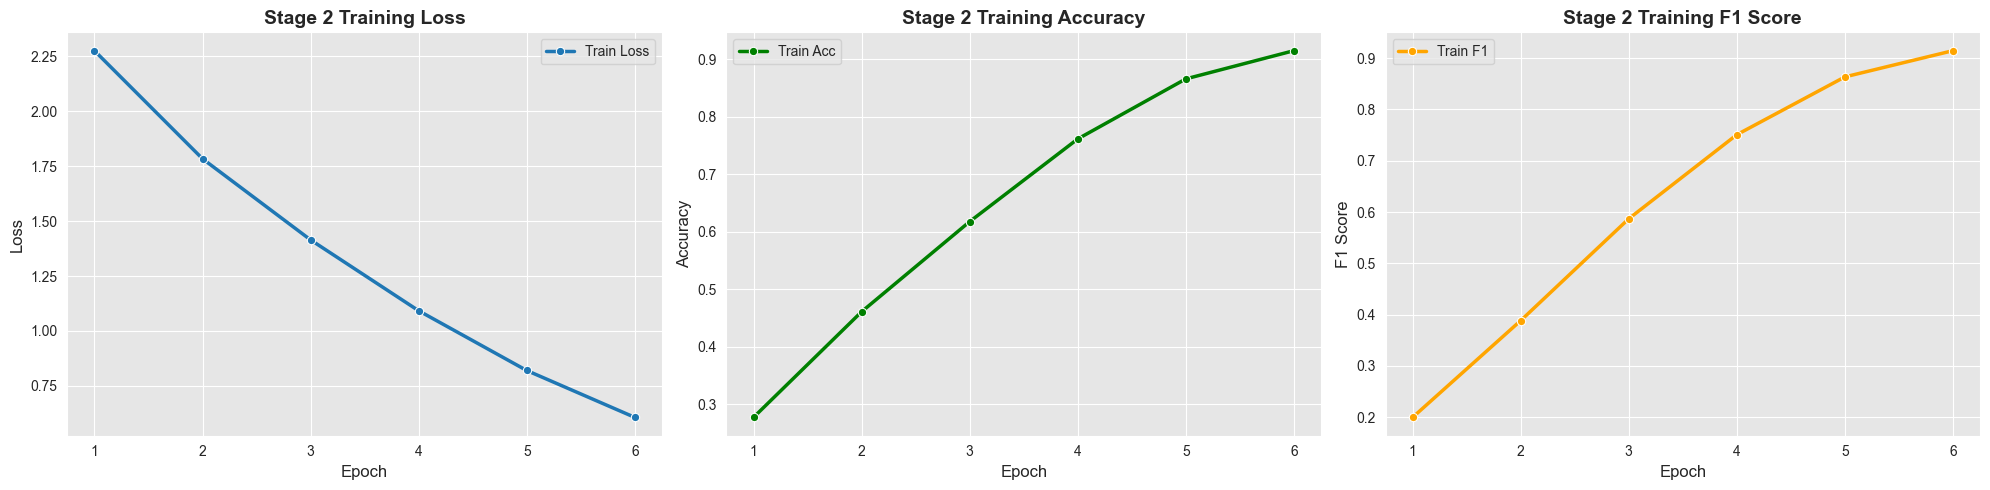

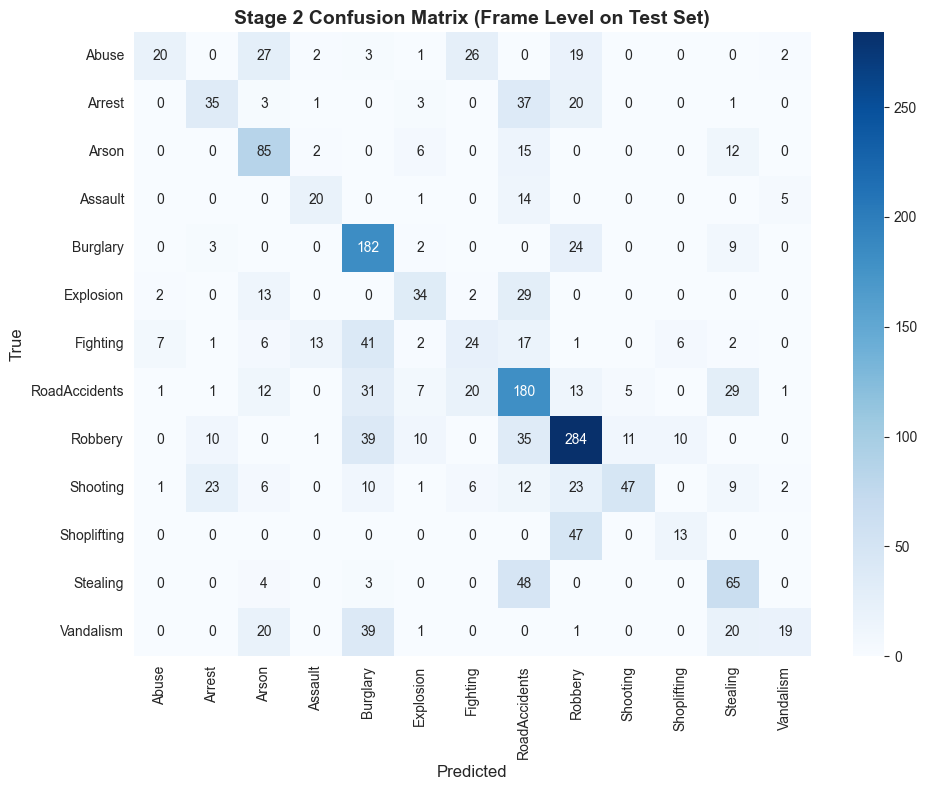

In [ ]:
# --- STAGE 2 EVALUATION AND VISUALIZATION ---

def evaluate_stage2(loader, model, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    return acc, f1, cm

# Evaluate on test set
test_acc, test_f1, test_cm = evaluate_stage2(test_loader_s2, model_s2, train_ds_s2.classes)
print(f"Stage 2 Test Accuracy: {test_acc*100:.2f}%")
print(f"Stage 2 Test F1 Score: {test_f1:.4f}")

# Set seaborn style
sns.set_style("darkgrid", {"axes.facecolor": ".9", "grid.color": "white"})

# Plot training metrics
epochs = range(1, len(stage2_history['train_loss']) + 1)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Loss plot
sns.lineplot(x=epochs, y=stage2_history['train_loss'], marker='o', ax=axes[0], 
             label='Train Loss', linewidth=2.5)
axes[0].set_title('Stage 2 Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].set_xticks(list(epochs))
axes[0].grid(True, alpha=1.0)

# Accuracy plot
sns.lineplot(x=epochs, y=stage2_history['train_acc'], marker='o', ax=axes[1], 
             label='Train Acc', linewidth=2.5, color='green')
axes[1].set_title('Stage 2 Training Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].set_xticks(list(epochs))
axes[1].grid(True, alpha=1.0)

# F1 Score plot
sns.lineplot(x=epochs, y=stage2_history['train_f1'], marker='o', ax=axes[2], 
             label='Train F1', linewidth=2.5, color='orange')
axes[2].set_title('Stage 2 Training F1 Score', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].legend()
axes[2].set_xticks(list(epochs))
axes[2].grid(True, alpha=1.0)

plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', 
            xticklabels=train_ds_s2.classes, 
            yticklabels=train_ds_s2.classes, 
            cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Stage 2 Confusion Matrix (Frame Level on Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

STAGE 2: VIDEO-LEVEL CLASSIFICATION

Stage 2 Video-Level Test Accuracy: 54.74%
Stage 2 Video-Level Test F1 Score: 0.5239
Total Videos Evaluated: 95


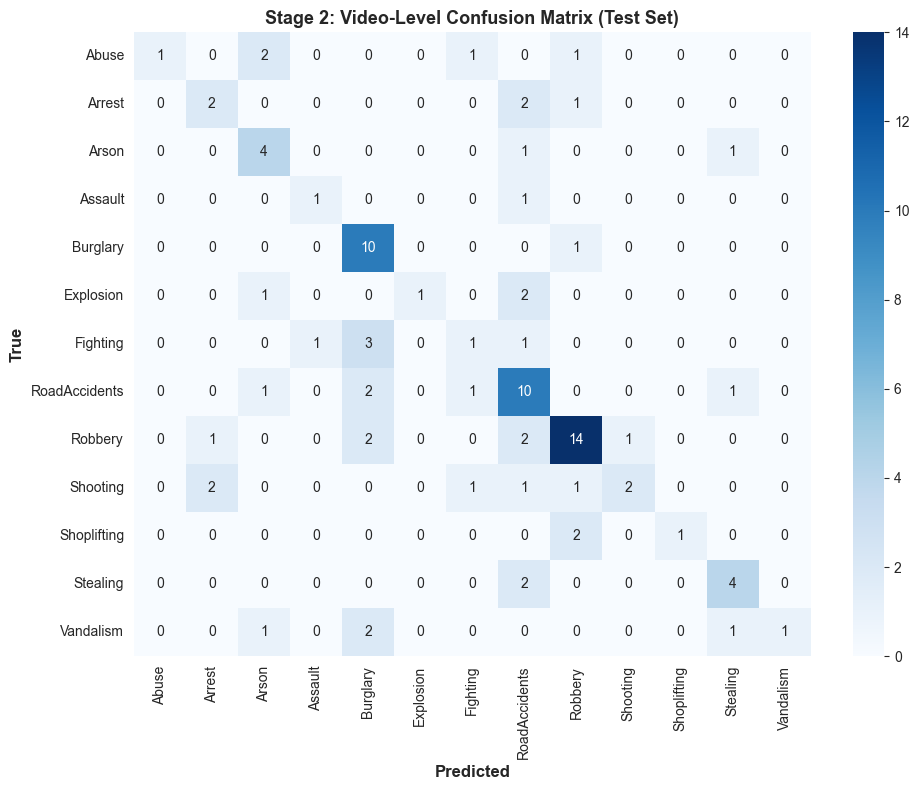


PERFORMANCE COMPARISON
Stage 2 (Frame-Level) Accuracy: 53.05%
Stage 2 (Video-Level) Accuracy: 54.74%

Stage 2 (Frame-Level) F1 Score: 0.5092
Stage 2 (Video-Level) F1 Score: 0.5239


In [ ]:


def aggregate_frames_to_video_predictions(model, dataset_root, split_name, classes):
    """
    Aggregate frame-level predictions to video-level predictions.
    For each video, takes the most common predicted class across its frames.
    """
    model.eval()
    
    split_path = os.path.join(dataset_root, split_name)
    video_predictions = {}
    video_true_labels = {}
    video_frame_predictions = {}
    video_probabilities = {}  # NEW: Store probabilities
    
    # Iterate through each class folder
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Group frames by video name
        video_frames = {}
        for frame_file in os.listdir(class_path):
            if not frame_file.endswith('.jpg'):
                continue
            
            # Extract video name (format: VideoName_rankN.jpg)
            video_name = '_'.join(frame_file.split('_')[:-1])
            
            if video_name not in video_frames:
                video_frames[video_name] = []
            
            video_frames[video_name].append(os.path.join(class_path, frame_file))
        
        # Process each video
        for video_name, frame_paths in video_frames.items():
            frame_preds = []
            frame_probs = []  # NEW: Store frame probabilities
            
            with torch.no_grad():
                for frame_path in frame_paths:
                    # Load and preprocess frame
                    img = Image.open(frame_path).convert('RGB')
                    img_tensor = transform_s2(img).unsqueeze(0).to(DEVICE)
                    
                    # Get prediction
                    output = model(img_tensor)
                    probs = torch.nn.functional.softmax(output, dim=1)  # NEW: Get probabilities
                    _, pred_idx = torch.max(output, 1)
                    pred_class = classes[pred_idx.item()]
                    
                    frame_preds.append(pred_class)
                    frame_probs.append(probs.cpu().numpy()[0])  # NEW: Store probabilities
            
            # Store frame predictions for this video
            video_frame_predictions[video_name] = frame_preds
            
            # Aggregate: Most common prediction
            from collections import Counter
            most_common_pred = Counter(frame_preds).most_common(1)[0][0]
            
            # NEW: Average probabilities across frames
            avg_probs = np.mean(frame_probs, axis=0)
            
            video_predictions[video_name] = most_common_pred
            video_true_labels[video_name] = class_name
            video_probabilities[video_name] = avg_probs  # NEW
    
    return video_predictions, video_true_labels, video_frame_predictions, video_probabilities  # NEW: Return probabilities


def evaluate_video_level(video_predictions, video_true_labels, classes):
    """
    Evaluate video-level classification performance.
    
    Args:
        video_predictions: Dict mapping video name to predicted class
        video_true_labels: Dict mapping video name to true class
        classes: List of class names
    
    Returns:
        accuracy, f1_score, confusion_matrix
    """
    # Convert to lists for sklearn metrics
    true_labels = []
    pred_labels = []
    
    for video_name in video_predictions.keys():
        true_labels.append(video_true_labels[video_name])
        pred_labels.append(video_predictions[video_name])
    
    # Calculate metrics
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)
    
    return acc, f1, cm, true_labels, pred_labels


# Run Stage 2 evaluation on test set
print("=" * 70)
print("STAGE 2: VIDEO-LEVEL CLASSIFICATION")
print("=" * 70)

video_preds_test, video_true_test, video_frame_preds_test, video_probs_test = aggregate_frames_to_video_predictions(
    model_s2, STAGE_2_DATA_ROOT, "Test", train_ds_s2.classes
)

video_acc, video_f1, video_cm, true_labels, pred_labels = evaluate_video_level(
    video_preds_test, video_true_test, train_ds_s2.classes
)

print(f"\nStage 2 Video-Level Test Accuracy: {video_acc*100:.2f}%")
print(f"Stage 2 Video-Level Test F1 Score: {video_f1:.4f}")
print(f"Total Videos Evaluated: {len(video_preds_test)}")


# Visualize video-level confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(video_cm, annot=True, fmt='d', xticklabels=train_ds_s2.classes, 
            yticklabels=train_ds_s2.classes, cmap='Blues')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Stage 2: Video-Level Confusion Matrix (Test Set)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare Stage 2 (frame-level) vs Stage 2 (video-level) performance
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)
print(f"Stage 2 (Frame-Level) Accuracy: {test_acc*100:.2f}%")
print(f"Stage 2 (Video-Level) Accuracy: {video_acc*100:.2f}%")
print(f"\nStage 2 (Frame-Level) F1 Score: {test_f1:.4f}")
print(f"Stage 2 (Video-Level) F1 Score: {video_f1:.4f}")
print("=" * 70)

In [38]:
# --- GENERATE VIDEO-LEVEL ROC CURVES (CORRECTED FOR MAJORITY VOTE) ---

def get_video_level_scores_from_majority_vote(model, dataset_root, split_name, classes):
    """
    Get video-level scores based on the confidence of the majority vote prediction.
    This better reflects what's actually happening in your evaluation.
    """
    model.eval()
    
    split_path = os.path.join(dataset_root, split_name)
    video_scores = {}
    video_predictions = {}
    video_true_labels = {}
    
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Group frames by video name
        video_frames = {}
        for frame_file in os.listdir(class_path):
            if not frame_file.endswith('.jpg'):
                continue
            
            video_name = '_'.join(frame_file.split('_')[:-1])
            
            if video_name not in video_frames:
                video_frames[video_name] = []
            
            video_frames[video_name].append(os.path.join(class_path, frame_file))
        
        # Process each video
        for video_name, frame_paths in video_frames.items():
            frame_preds = []
            frame_probs_for_pred = []
            
            with torch.no_grad():
                for frame_path in frame_paths:
                    img = Image.open(frame_path).convert('RGB')
                    img_tensor = transform_s2(img).unsqueeze(0).to(DEVICE)
                    
                    output = model(img_tensor)
                    probs = torch.nn.functional.softmax(output, dim=1)
                    
                    _, pred_idx = torch.max(output, 1)
                    pred_class = classes[pred_idx.item()]
                    pred_confidence = probs[0, pred_idx.item()].cpu().numpy()
                    
                    frame_preds.append(pred_class)
                    frame_probs_for_pred.append((pred_class, pred_confidence))
            
            # Get majority vote prediction
            from collections import Counter
            vote_counts = Counter(frame_preds)
            majority_class = vote_counts.most_common(1)[0][0]
            
            # Score is the average confidence for frames that voted for the majority class
            confidences_for_majority = [conf for cls, conf in frame_probs_for_pred if cls == majority_class]
            avg_confidence = np.mean(confidences_for_majority)
            
            video_predictions[video_name] = majority_class
            video_true_labels[video_name] = class_name
            video_scores[video_name] = {cls: 0.0 for cls in classes}
            video_scores[video_name][majority_class] = avg_confidence
    
    return video_scores, video_predictions, video_true_labels


Total videos: 95
Class Abuse: 5 positive samples, AUC: 0.500
Class Arrest: 5 positive samples, AUC: 0.472
Class Arson: 5 positive samples, AUC: 0.657
Class Assault: 5 positive samples, AUC: 0.494
Class Burglary: 10 positive samples, AUC: 0.808
Class Explosion: 5 positive samples, AUC: 0.494
Class Fighting: 5 positive samples, AUC: 0.478
Class RoadAccidents: 15 positive samples, AUC: 0.629
Class Robbery: 15 positive samples, AUC: 0.677
Class Shooting: 5 positive samples, AUC: 0.494
Class Shoplifting: 5 positive samples, AUC: 0.600
Class Stealing: 10 positive samples, AUC: 0.785
Class Vandalism: 5 positive samples, AUC: 0.500


C:\Users\Brandon\AppData\Local\Temp\ipykernel_4136\2041281325.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_4136\2041281325.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_4136\2041281325.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_4136\2041281325.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_4136\2041281325.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Brandon\AppData\Local\Temp\ipykernel_4136\2041281325.py:48: FutureWarning: 

The `ci` parameter is de

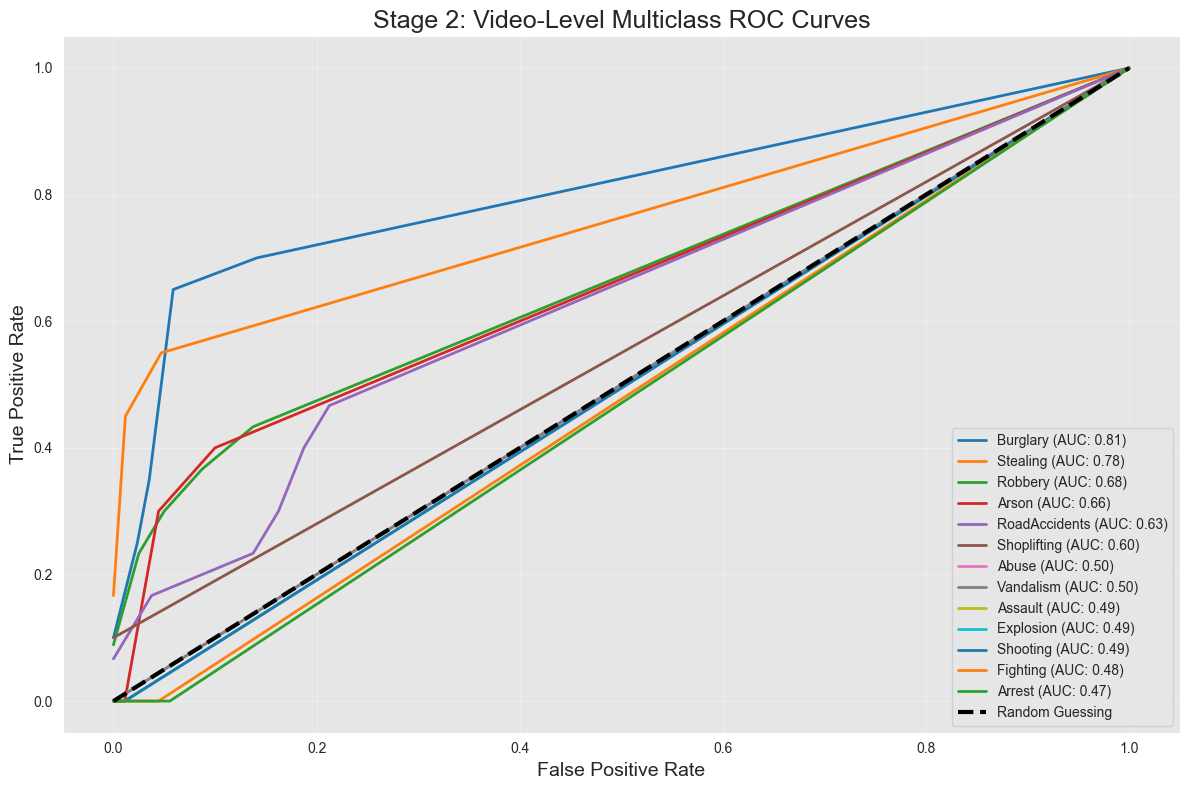

In [43]:

# Get video-level data
video_scores_dict, video_preds_dict, video_true_dict = get_video_level_scores_from_majority_vote(
    model_s2, STAGE_2_DATA_ROOT, "Test", train_ds_s2.classes
)

# Prepare data for ROC
classes = train_ds_s2.classes
n_classes = len(classes)
video_names = list(video_scores_dict.keys())
video_true_labels_list = [video_true_dict[name] for name in video_names]

# Create score matrix (each video gets a score for each class)
video_scores_array = np.zeros((len(video_names), n_classes))
for i, video_name in enumerate(video_names):
    for j, class_name in enumerate(classes):
        video_scores_array[i, j] = video_scores_dict[video_name][class_name]

print(f"\nTotal videos: {len(video_names)}")

# --- Seaborn style ---
sns.set_style("darkgrid", {"axes.facecolor": ".9", "grid.color": "white"})

fig, ax = plt.subplots(figsize=(12, 8))

# --- Compute ROC for each class ---
roc_data = []
for i, class_name in enumerate(classes):
    binary_labels = np.array([1 if label == class_name else 0 for label in video_true_labels_list])
    
    # Use the scores for this class
    class_scores = video_scores_array[:, i]
    
    # Only compute ROC if we have both positive and negative samples
    if binary_labels.sum() > 0 and binary_labels.sum() < len(binary_labels):
        fpr, tpr, _ = roc_curve(binary_labels, class_scores)
        roc_auc = auc(fpr, tpr)
        roc_data.append((class_name, fpr, tpr, roc_auc))
        print(f"Class {class_name}: {binary_labels.sum()} positive samples, AUC: {roc_auc:.3f}")
    else:
        print(f"Class {class_name}: Skipped (only one class present)")

# --- Sort by descending AUC ---
roc_data.sort(key=lambda x: x[3], reverse=True)

# --- Plot ROC curves (sorted) ---
palette = sns.color_palette("tab10", len(roc_data))
for i, (class_name, fpr, tpr, roc_auc) in enumerate(roc_data):
    sns.lineplot(
        x=fpr,
        y=tpr,
        ax=ax,
        lw=2,
        label=f"{class_name} (AUC: {roc_auc:.2f})",
        color=palette[i],
        ci=None
    )

# --- Random guessing line ---
sns.lineplot(x=[0, 1], y=[0, 1], color="black", lw=3, linestyle="--", label="Random Guessing", ax=ax)

# --- Finalize plot ---
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.set_title("Stage 2: Video-Level Multiclass ROC Curves", fontsize=18)
ax.legend(fontsize=10, loc="lower right")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()